In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from mimic_calibration import _MimicCalibration

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
n_samples = 1000
X, y = make_classification(n_samples=3 * n_samples, n_features=6,random_state=42)
X -= X.min()

# Train data: train binary model.
X_train, y_train = X[:n_samples], y[:n_samples]
# calibrate data.
X_calib, y_calib = X[n_samples:2 * n_samples], y[n_samples:2 * n_samples]
# test data.
X_test, y_test = X[2 * n_samples:], y[2 * n_samples:]
clf = MultinomialNB().fit(X_train, y_train)

# y_calib_score: training in the calibration model.
y_calib_score = clf.predict_proba(X_calib)
y_calib_score = np.array([ score[1] for score in y_calib_score])

# y_test_score: evaluation in the calibration model.
y_test_score = clf.predict_proba(X_test)
y_test_score = np.array([ score[1] for score in y_test_score])

In [4]:
print(y_calib[:10])
print(y_calib_score[:10])

[1 0 0 1 1 1 1 1 0 0]
[ 0.72519729  0.56204016  0.37790463  0.61490316  0.70866065  0.62202329
  0.5139929   0.66173912  0.31795471  0.48888974]


In [5]:
print(y_test[:10])
print(y_test_score[:10])

[0 1 1 1 1 0 1 1 0 0]
[ 0.34887991  0.69543327  0.60747915  0.71507848  0.7973931   0.38229876
  0.33457182  0.59589857  0.32839148  0.42775544]


### MIMIC Calibration

In [6]:
mimicObject = _MimicCalibration(threshold_pos=5, record_history=True)
mimicObject.fit(y_calib_score, y_calib)
y_mimic_score = mimicObject.predict(y_test_score)

### IsotonicRegression

In [7]:
from sklearn.isotonic import IsotonicRegression
isoObject = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds='clip')
isoObject.fit(y_calib_score, y_calib)
y_iso_score = isoObject.predict(y_test_score)

### Platt calibration (ie logistic regression)

In [8]:
from sklearn.linear_model import LogisticRegression
LRObject = LogisticRegression()
LRObject.fit(y_calib_score.reshape(-1,1), y_calib)
y_platt_score = LRObject.predict_proba(y_test_score.reshape(-1,1))[:,1]

//anaconda/envs/mimic-env-2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


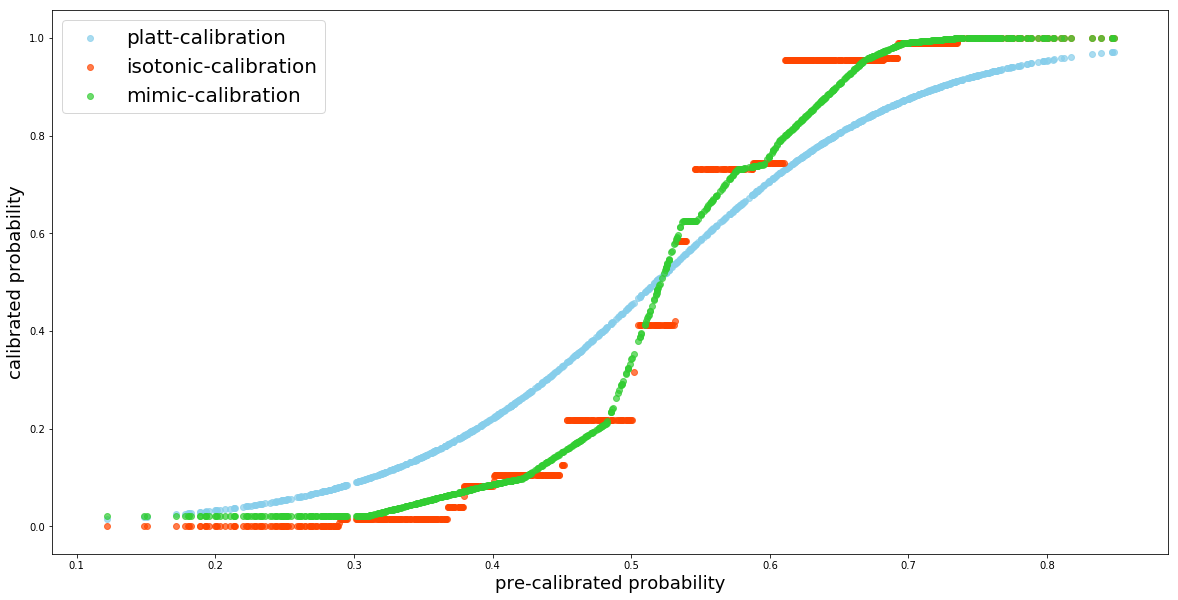

In [20]:
fig = plt.figure() # limegreen, mediumblue
plt.scatter(y_test_score,y_platt_score, color ='skyblue',label = "platt-calibration", alpha= 0.7)
plt.scatter(y_test_score,y_iso_score, color ='orangered',label = "isotonic-calibration", alpha= 0.7)
plt.scatter(y_test_score,y_mimic_score, color ='limegreen',label = "mimic-calibration", alpha= 0.7)
plt.xlabel("pre-calibrated probability", fontsize=18)
plt.ylabel("calibrated probability", fontsize=18)
plt.legend(fontsize=20)
fig.savefig("mimic_calib_prob.png")

plot history size: 20


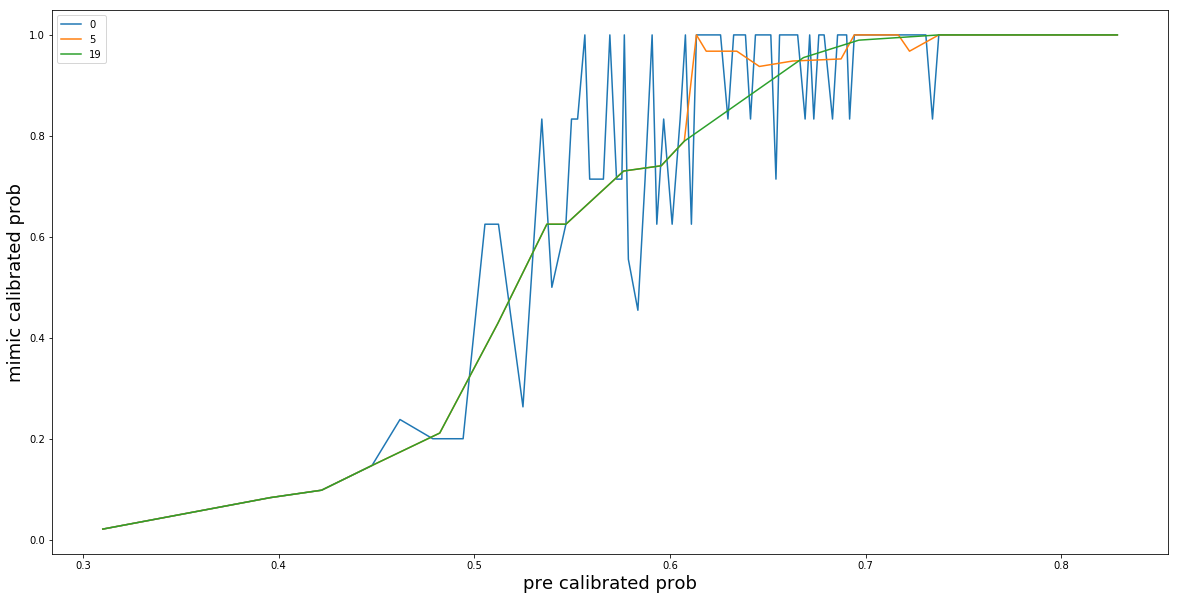

In [10]:
history = mimicObject.history_record_table
mimicObject.plot_history_result([0, 5, 19])